In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import os
import warnings
warnings.filterwarnings("ignore")

class AudioAnalyzer:
    def __init__(self):
        self.audio_conf = {}
        self.windows = {'hamming': scipy.signal.hamming,
        'hann': scipy.signal.hann, 'blackman': scipy.signal.blackman,
           'bartlett': scipy.signal.bartlett}
    def preemphasis(self,signal,coeff=0.97):
        """perform preemphasis on the input signal.
        
        :param signal: The signal to filter.
        :param coeff: The preemphasis coefficient. 0 is none, default 0.97.
        :returns: the filtered signal.
        """    
        return np.append(signal[0],signal[1:]-coeff*signal[:-1])
    
    def load_audio_DAVENet(self, file):
        audio_type = self.audio_conf.get('audio_type', 'melspectrogram')
        if audio_type not in ['melspectrogram', 'spectrogram']:
            raise ValueError('Invalid audio_type specified in audio_conf. Must be one of [melspectrogram, spectrogram]')
        preemph_coef = self.audio_conf.get('preemph_coef', 0.97)
        sample_rate = self.audio_conf.get('sample_rate', 16000)
        window_size = self.audio_conf.get('window_size', 0.025)
        window_stride = self.audio_conf.get('window_stride', 0.01)
        window_type = self.audio_conf.get('window_type', 'hamming')
        num_mel_bins = self.audio_conf.get('num_mel_bins', 40)
        target_length = self.audio_conf.get('target_length', 2048)
        use_raw_length = self.audio_conf.get('use_raw_length', False)
        padval = self.audio_conf.get('padval', 0)
        fmin = self.audio_conf.get('fmin', 20)
        n_fft = self.audio_conf.get('n_fft', int(sample_rate * window_size))
        win_length = int(sample_rate * window_size)
        hop_length = int(sample_rate * window_stride)
        print(f"STFT parameters:\n\tn_fft {n_fft}\n\twin_lenght {win_length}\n\thop_length {hop_length}")
        # load audio, subtract DC, preemphasis
        y, sr = librosa.load(file,sr=sample_rate)
        
        if y.size == 0:
            y = np.zeros(200)
        y = y - y.mean()
        y = self.preemphasis(y, preemph_coef)
        # compute mel spectrogram
        stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
            win_length=win_length,
            window=self.windows.get(window_type, self.windows['hamming']),
            center=True)
        spec = np.abs(stft)**2
        # if audio_type == 'melspectrogram':
        mel_basis = librosa.filters.mel(sr, n_fft, n_mels=num_mel_bins, fmin=fmin)
        melspec = np.dot(mel_basis, spec)
        logmelspec = librosa.power_to_db(melspec, ref=np.max)
        # elif audio_type == 'spectrogram':
        logspec = librosa.power_to_db(spec, ref=np.max)
        n_frames = logmelspec.shape[1]
        if use_raw_length:
            target_length = n_frames
        p = target_length - n_frames
        if p > 0:
            logmelspec = np.pad(logmelspec, ((0,0),(0,p)), 'constant',
                constant_values=(padval,padval))
        elif p < 0:
            logmelspec = logmelspec[:,0:p]
            n_frames = target_length
        # logspec = torch.FloatTensor(logspec)
        # return logspec, n_frames
        # return logspec.unsqueeze(0)
        return logspec,logmelspec, n_frames
    
def get_silence_ranges(y_db,sr=16000, threshold = -50, min_silence_length=0.5):
    
    # Find silence regions
    s_ranges = []
    start = None

    for i in range(len(y_db)):
       
        if y_db[i] < threshold:
            if start is None:
                start = i
        
        else:
            if start is not None:
                duration = (i - start) / sr
                if duration >= min_silence_length:
                    s_ranges.append((start / sr, i / sr))
                start = None
    if start is not None:
        duration = (i - start) / sr
        if duration >= min_silence_length:
            s_ranges.append((start / sr, len(y_db) / sr))

    return s_ranges
    

audio_dir = "dir_exp_PlacesAudio/audio"
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]


In [ ]:
def map_silence_rang_from_t2f(silence_ranges,nFrames,sr=16000):
    """
        Every frame is 0.01 secs, 160 samples
        sr 16khz default
    """
    
    for r in silence_ranges:
        



audio 15th: utterance_187322.wav
nSamples 106255
sample rate 16000
length in seconds 6.6409375
STFT parameters:
	n_fft 400
	win_lenght 400
	hop_length 160
nFrames 665
range 1 start 0.0 finish 1.28225
range 2 start 2.3709375 finish 2.6930625
range 3 start 4.0141875 finish 4.5114375
range 4 start 6.1903125 finish 6.6409375


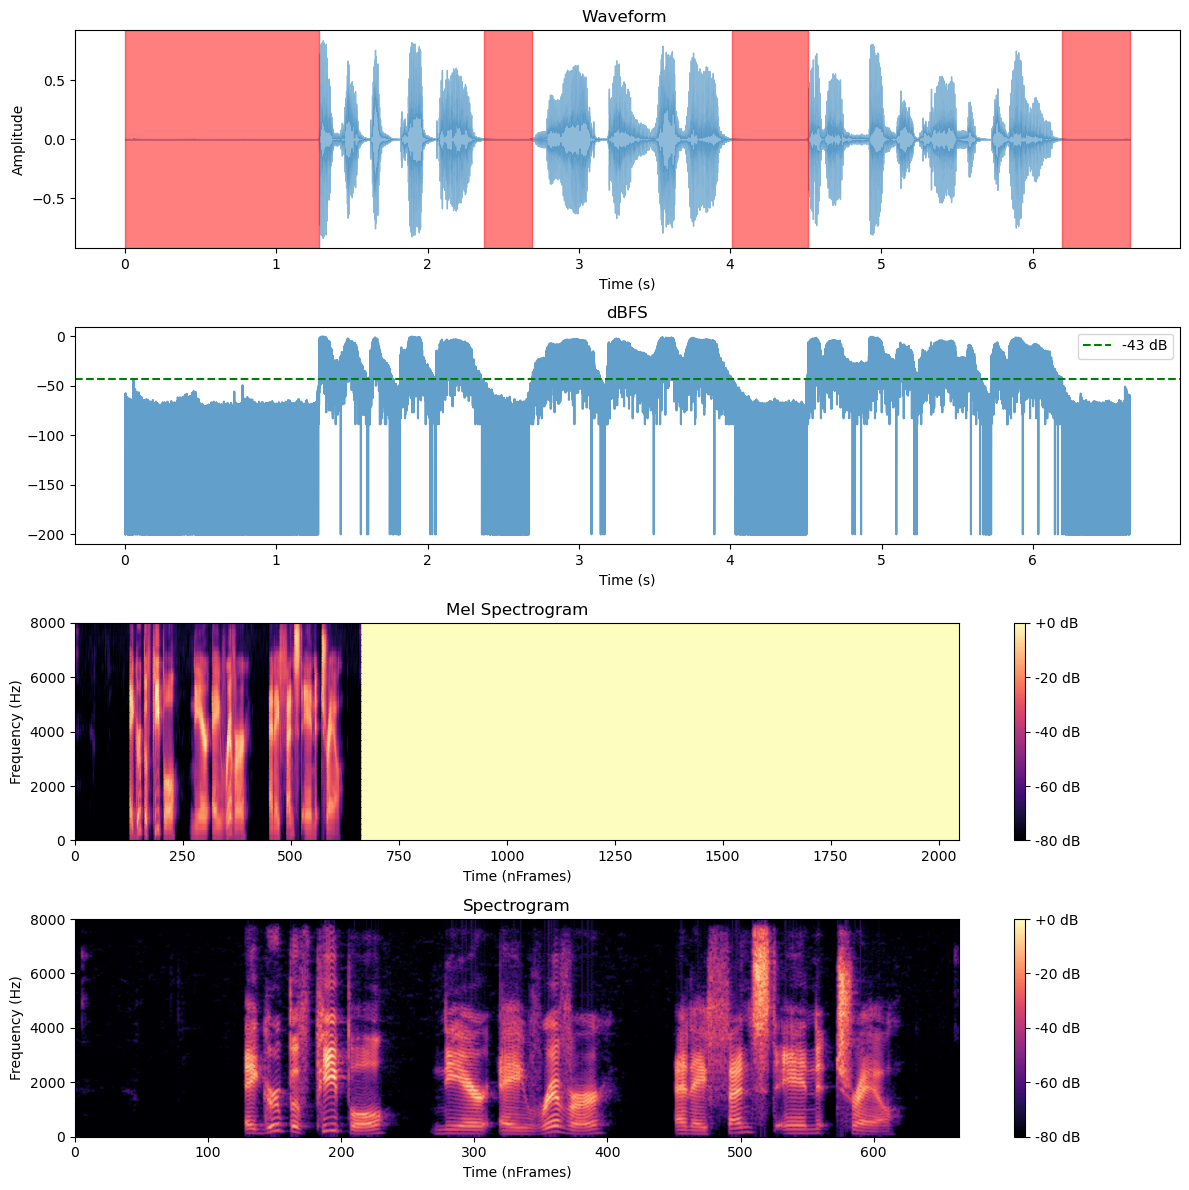

In [2]:
import random
idx = random.randint(0, len(audio_files) - 1)
# audio_path = os.path.join(audio_dir, audio_files[idx])
audio_path = os.path.join(audio_dir,"utterance_183783.wav")
print(f"audio {idx}th:", audio_files[idx])

y,sr = librosa.load(audio_path,sr=None)
print("nSamples", len(y))
print("sample rate",sr)
print("length in seconds", len(y)/sr)
peak = np.max(np.abs(y))
y_dbfs = 20*np.log10(np.abs(y)/ peak + 1e-10)

specmaker = AudioAnalyzer()

spec, melspec, nframes = specmaker.load_audio_DAVENet(audio_path)
print("nFrames", nframes)
threshold = -43
silence_ranges = get_silence_ranges(y_dbfs,threshold=threshold,min_silence_length=0.3)
for i,r in enumerate(silence_ranges):
    print(f"range {i+1} start {r[0]} finish {r[1]}")

plt.figure(figsize=(12,12))

plt.subplot(4,1,1)
librosa.display.waveshow(y, sr=sr, alpha=0.5)
for start, end in silence_ranges:
    plt.axvspan(start, end, color='red', alpha=0.5, label='Silence')
plt.title('Waveform ')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')



plt.subplot(4,1,2)
plt.plot(np.arange(len(y_dbfs)) / sr, y_dbfs, alpha=0.7)
plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold} dB')
plt.legend()
plt.title('dBFS')
plt.xlabel('Time (s)')

plt.subplot(4,1,3)
im = plt.pcolormesh(np.arange(melspec.shape[1]), np.linspace(0, sr / 2, melspec.shape[0]), melspec, shading='gouraud', cmap='magma')
plt.colorbar(im, format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time (nFrames)')
plt.ylabel('Frequency (Hz)')

plt.subplot(4,1,4)
im = plt.pcolormesh(np.arange(spec.shape[1]), np.linspace(0, sr / 2, spec.shape[0]), spec, shading='gouraud', cmap='magma')
plt.colorbar(im, format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (nFrames)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()


ipd.Audio(audio_path)
